In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom
# from assistant import *

# Misc
import fim
import sqlite3
import re
import os
import joblib
from PIL import Image
from urllib.parse import urljoin
from tqdm.notebook import tqdm

# NLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Clustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import (KMeans,
                             AgglomerativeClustering,
                             DBSCAN, OPTICS, cluster_optics_dbscan)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from scipy.spatial.distance import euclidean, cityblock, cosine
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             silhouette_score, adjusted_mutual_info_score,
                             adjusted_rand_score, confusion_matrix)

# sns.set_theme('notebook', 'darkgrid', 'colorblind')

## Helper functions

In [3]:
def save_pkl(obj, name, prompt=True):
    """Save an object to a pickle file."""
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        os.makedirs(folder)
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    joblib.dump(obj, fp)
    if prompt:
        print('Object pickled for future use.')
    return

def load_pkl(name, prompt=False):
    """Load an object from a pickle file."""
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        raise ValueError("'pickles' folder does not exist.")
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    pkl = joblib.load(fp)
    if prompt:
        print('Pickle file loaded.')
    return pkl

def lemmatize(series, stop_words, lemmatizer=WordNetLemmatizer()):
    """
    Return a pandas Series of the lemmatized review text data.
    """
    def clean_text(text, stop_words, lemmatizer):
        """Preprocess the text using lemmatization."""
        text = text.casefold()
        text_list = [
            lemmatizer.lemmatize(word)
            for word in re.findall(r'\b[a-z-]+\b', text)
            if word not in stop_words
        ]
        return ' '.join(text_list)

    lemmd_text = (
        series.apply(lambda x: clean_text(x, stop_words, lemmatizer))
    )
    return lemmd_text

def vectorize(corpus, params):
    """
    Vectorize the corpus of reviews using `model`.
    """
    vectorizer = TfidfVectorizer(**params)
    sparse_corpus = vectorizer.fit_transform(corpus)
    corpus_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_corpus, columns=vectorizer.get_feature_names_out()
    )
    return corpus_df

def cl_cluster_range(tfidf_matrix, n_clusters=9):
    """
    Cluster the input matrix using KMeans
    """
    cluster_dict = {}
    val_metrics = {'sse': [], 'ch': [], 'sh': [], 'db': []}
    for k in tqdm(range(2, n_clusters+2)):
        kmeans = KMeans(n_clusters=k, random_state=1337)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        cluster_dict.update(
            {k: {'model': kmeans, 'labels': cluster_labels}}
        )
        val_metrics['sse'].append(kmeans.inertia_)
        val_metrics['ch'].append(calinski_harabasz_score(
            tfidf_matrix.to_numpy(), cluster_labels
        ))
        val_metrics['sh'].append(silhouette_score(
            tfidf_matrix.to_numpy(), cluster_labels
        ))
        val_metrics['db'].append(davies_bouldin_score(
            tfidf_matrix.to_numpy(), cluster_labels
        ))
    cluster_dict.update({'metrics': val_metrics})
    return cluster_dict

def cl_project_features(
    tfidf_matrix,
    cluster_dict,
    num_feats=15,
    return_fig=False
):
    """
    Project the features of the TF-IDF matrix onto the SVD components.
    """
    svd = TruncatedSVD(n_components=tfidf_matrix.shape[1],
                   random_state=1337)
    transformed_profiles = pd.DataFrame(
        svd.fit_transform(tfidf_matrix),
        index=tfidf_matrix.index
    )
    sv_idx = np.argsort(svd.explained_variance_ratio_)[::-1]
    transformed_profiles = transformed_profiles.iloc[:, sv_idx]
    
    p = svd.components_.T
    features = tfidf_matrix.columns
    fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

    sns.scatterplot(ax=ax[0], x=transformed_profiles.iloc[:, 0],
                    y=transformed_profiles.iloc[:, 1])
    ax[0].set(xlabel='SV1', ylabel='SV2')

    top_feats = np.argsort(tfidf_matrix.sum().to_numpy())[::-1][:num_feats]

    for feature, vec in zip(features[top_feats], p[top_feats]):
        ax[1].arrow(0, 0, vec[0], vec[1], lw=6, ec='none', fc='r')
        ax[1].text(vec[0], vec[1], feature, ha='center', color='r',
                   fontsize=12)
    if return_fig:
        return fig
    return transformed_profiles

In [26]:
conn = sqlite3.connect(
            '/mnt/processed/private/msds2023/lt5/dmw2-project/amazon.db'
        )

## Function prefixes

1. `pr` : Pruning customers and products
1. `vc` : Creation of TFIDF matrix
1. `cl` : Clustering
1. `cb` : Content-based recommender system

In [4]:
def pr_prune_data(cust_thresh=62, prod_thresh=610):
    """
    Prune the number of customers and products to consider based on
    thresholds. Return a dataframe of reviews corresponding to considered
    customers and products only.
    """
    try:
        amazon_df = load_pkl('amazon_df')
    except:
        conn = sqlite3.connect(
            '/mnt/processed/private/msds2023/lt5/dmw2-project/amazon.db'
        )
        query = '''
            SELECT customer_id, product_id
            FROM ratings
        '''
        ratings_df = pd.read_sql(query, conn)

        cust_count = ratings_df.customer_id.value_counts()
        prod_count = ratings_df.product_id.value_counts()

        considered_customers = (
            cust_count[cust_count > cust_thresh].index.tolist()
        )
        considered_products = (
            prod_count[prod_count > prod_thresh].index.tolist()
        )

        query = f'''
            SELECT
                reviews.review_id,
                ratings.customer_id,
                ratings.product_id,
                ratings.star_rating,
                reviews.review_headline,
                reviews.review_body
            FROM reviews
            INNER JOIN ratings ON reviews.review_id = ratings.review_id
            WHERE ratings.customer_id IN {tuple(considered_customers)}
            AND ratings.product_id IN {tuple(considered_products)};
        '''
        amazon_df = pd.read_sql(query, conn)
        amazon_df.star_rating = (
            amazon_df.star_rating.astype(float).astype(int)
        )
        save_pkl(amazon_df, 'amazon_df')
    return amazon_df

def vc_get_tfidf(df, stop_words, params):
    """Construct the document-term matrix for Amazon reviews."""
    try:
        customer_profiles = load_pkl('customer_profiles')
        product_profiles = load_pkl('product_profiles')
    except:
        lemm_reviews = lemmatize(
            df.review_headline + ' ' + df.review_body,
            stop_words
        )
        docterm_matrix = vectorize(lemm_reviews, params)
        docterm_matrix.insert(0, 'product_id', df.product_id)
        docterm_matrix.insert(0, 'customer_id', df.customer_id)
        customer_profiles = (
            docterm_matrix.drop('product_id', axis=1)
            .groupby('customer_id').mean()
        )
        product_profiles = (
            docterm_matrix.drop('customer_id', axis=1)
            .groupby('product_id').mean()
        )
        save_pkl(customer_profiles, 'customer_profiles')
        save_pkl(product_profiles, 'product_profiles')
    return customer_profiles, product_profiles

def cl_plot_wc(cluster_dict, profiles, n_clusters, label, wc,
               cluster_name=None):
    """Plot a word cloud of the cluster."""
    fig = plt.figure(figsize=(6.4*2, 4.8*2))
    idx = np.argwhere(
        cluster_dict[n_clusters]['labels'] == label
    ).flatten()
    filtered_weights = profiles.iloc[idx].sum()
    plt.imshow(wc.generate_from_frequencies(filtered_weights),
                   interpolation='spline16')
    if cluster_name:
        plt.title(cluster_name)
    plt.axis('off')
    fig.canvas.draw()
    return fig

def cl_plot_all(cluster_dict, profiles, n_clusters, wc, cluster_names=None):
    """Plot a word cloud of the cluster."""
    fig, ax = plt.subplots(n_clusters, 2, figsize=(6.4*2, 4.8*n_clusters),
                           dpi=100)
    fig.subplots_adjust(wspace=0.4)
    ax = ax.flatten()
    for i, label in enumerate(np.unique(cluster_dict[n_clusters]['labels'])):
        idx = np.argwhere(
            cluster_dict[n_clusters]['labels'] == label
        ).flatten()
        filtered_weights = profiles.iloc[idx].sum()
        ax[2*i].imshow(wc.generate_from_frequencies(filtered_weights),
                       interpolation='spline16')
        if cluster_names is not None:
            ax[2*i].set_title(cluster_names[i])
        ax[2*i].set_axis_off()

        top_words = filtered_weights.sort_values(ascending=False).head(14)

        sns.barplot(x=top_words.to_numpy(), y=top_words.index, ax=ax[2*i+1],
                    color='gold')

In [7]:
amazon_df = pr_prune_data()

In [10]:
drop_words = ['let', 'one', 'two', 'three', 'four', 'five', 'star', 'product',
              'year', 'inch', 'warranty', 'x', 'recommend', 'well', 'great',
              'size', 'expected', 'best', 'excellent', 'inch', 'pack', 'px',
              'pk', 'ct'] + ['quality', 'recommend', 'item', 'wonderful',
              'must', 'ordered', 'order', 'wanted', 'want', 'super',
              'purchase', 'useful', 'arrived', 'arrive', 'awesome',
              'fantastic', 'quite', 'definitely', 'worked', 'pleased', 'sure',
              'know', 'every', 'second', 'purchased']

stop_words = list(set(
        stopwords.words('english') +
        list(STOPWORDS) +
        drop_words
))

tfidf_params = dict(
    ngram_range=(1, 2),
    token_pattern=r'[a-z-]{2,}',
    stop_words=stop_words,
    max_df=0.10,
    min_df=0.02,
    max_features=None
)

In [11]:
customer_profiles, product_profiles = vc_get_tfidf(
    amazon_df, stop_words, tfidf_params
)

## Clustering customers

In [16]:
mask = np.array(Image.open("amazon_mask.png"))

wc = WordCloud(
    font_path='AmazonEmberCdRC_Rg.ttf',
    width=800, height=800,
    mask=mask,
    background_color='darkslategray',
    colormap='Wistia',
    max_words=300,
    collocations = False,
    stopwords=stop_words,
    random_state=1337,
)

### KMeans

In [10]:
cust_cl_dict = cl_cluster_range(customer_profiles)

  0%|          | 0/9 [00:00<?, ?it/s]

### SVD

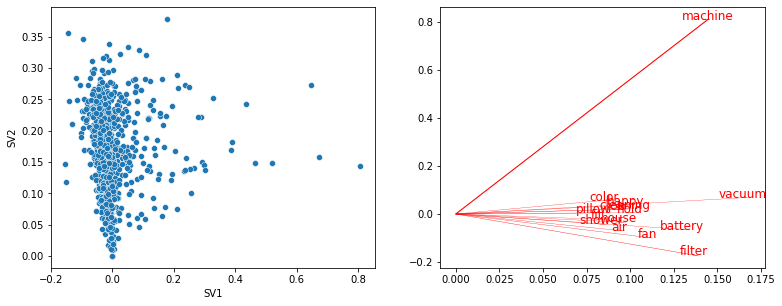

In [11]:
cust_svd_matrix = cl_project_features(
    customer_profiles, cust_cl_dict
)

### Grid search

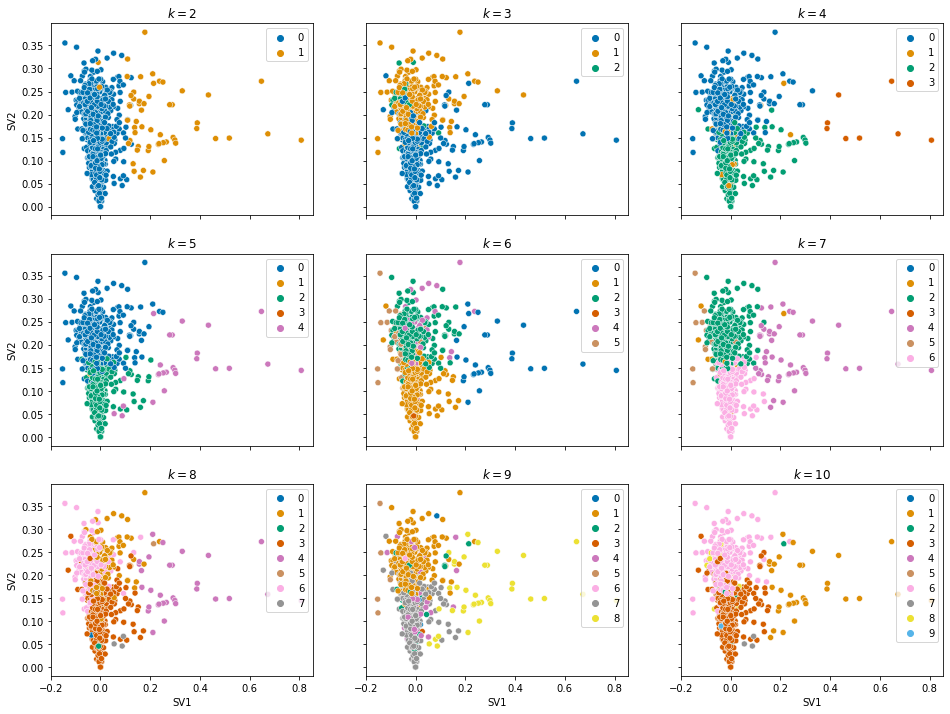

In [25]:
# Insert grid search plots and validation criteria here
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True,
                       figsize=(6.4*2.5, 4.8*2.5))
ax = ax.flatten()

for i, (k, results) in enumerate(list(cust_cl_dict.items())[:-1]):
    sns.scatterplot(x=cust_svd_matrix.iloc[:, 0],
                    y=cust_svd_matrix.iloc[:, 1],
                    hue=cust_cl_dict[k]['labels'], ax=ax[i], palette='colorblind')
    ax[i].set_title(f'$k={k}$')
    ax[i].set(xlabel='SV1', ylabel='SV2')

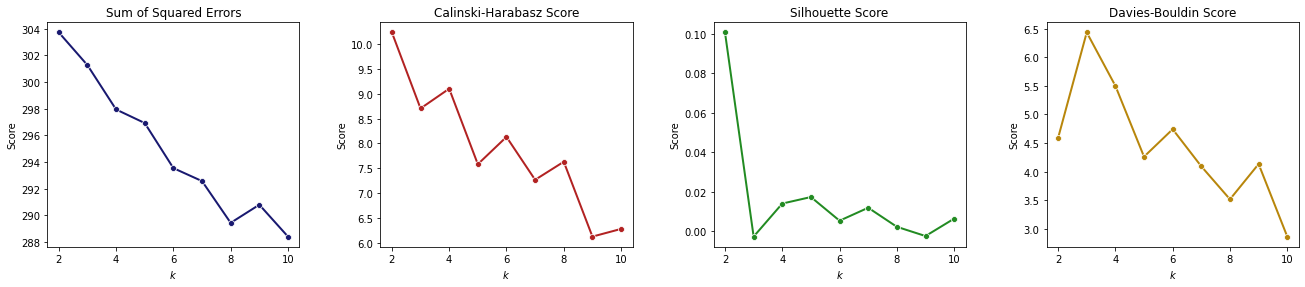

In [29]:
x_range = np.arange(2, len(cust_cl_dict)+1)

names = {'sse': 'Sum of Squared Errors', 'ch': 'Calinski-Harabasz Score',
         'sh': 'Silhouette Score', 'db': 'Davies-Bouldin Score'}
colors = ['midnightblue', 'firebrick', 'forestgreen', 'darkgoldenrod']

num_plots = 4

# try:
#     val_metrics.pop('sh')
#     names.pop('sh')
#     num_plots -= 1
# except:
#     pass

fig, ax = plt.subplots(1, num_plots, figsize=(6.4*3, 4.8))
fig.tight_layout(pad=5)
ax = ax.flatten()

for i, (name, score) in enumerate(cust_cl_dict['metrics'].items()):
    sns.lineplot(x=x_range, y=score, ax=ax[i],
                 color=colors[i], marker='o', lw=2).set(title=names[name])
    ax[i].set(xlabel='$k$', ylabel='Score')

### Word clouds

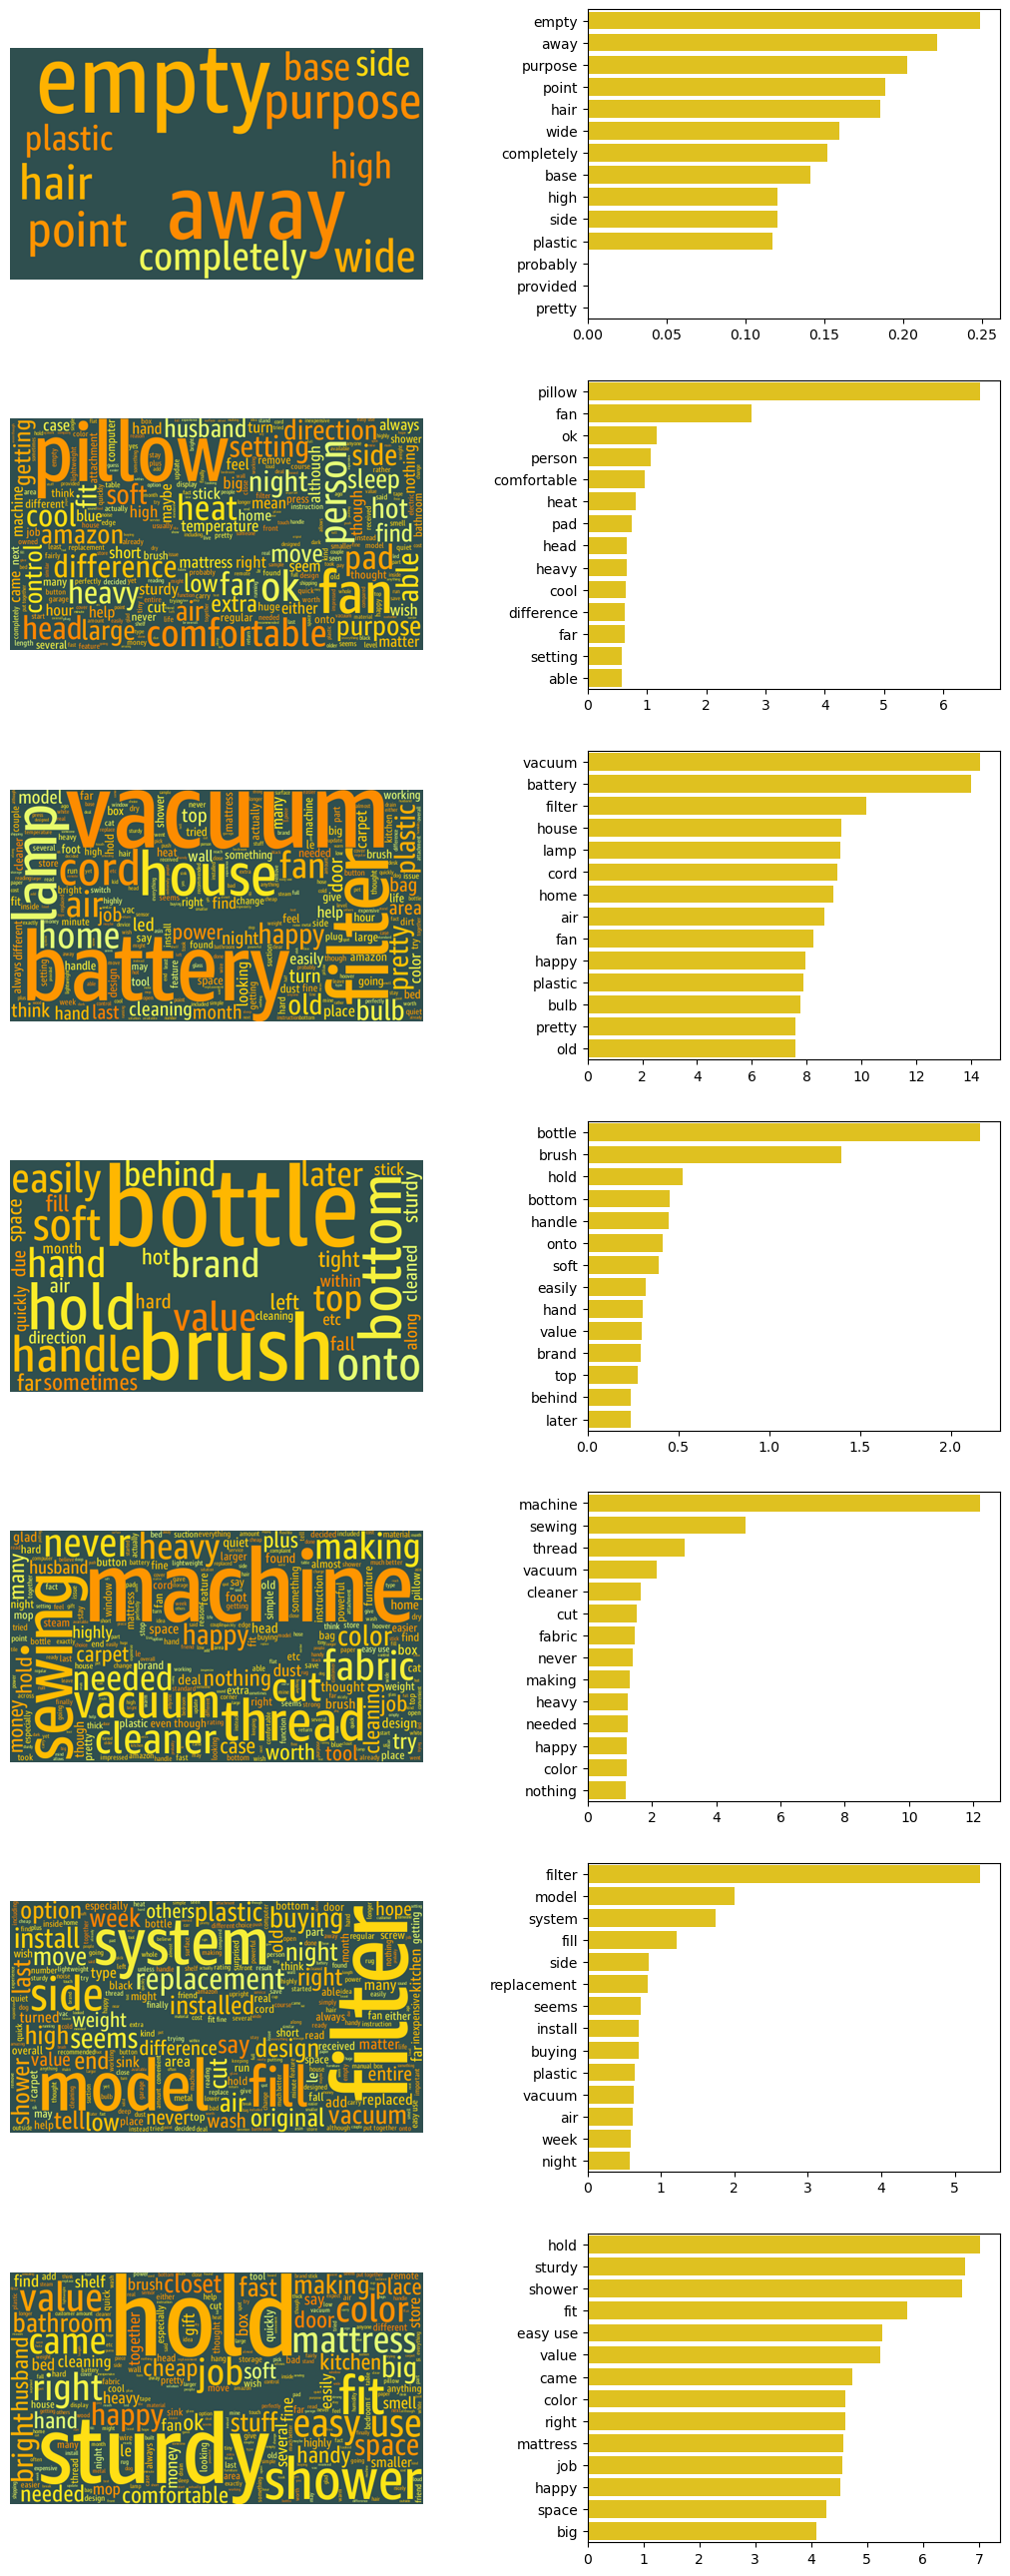

In [30]:
# cust_cl_names = ['Household Electronics', 'Home Furnishings']
cl_plot_all(cust_cl_dict, customer_profiles, 7, wc)

## Clustering Products

### KMeans

In [12]:
prod_cl_dict = cl_cluster_range(product_profiles)

  0%|          | 0/9 [00:00<?, ?it/s]

### SVD

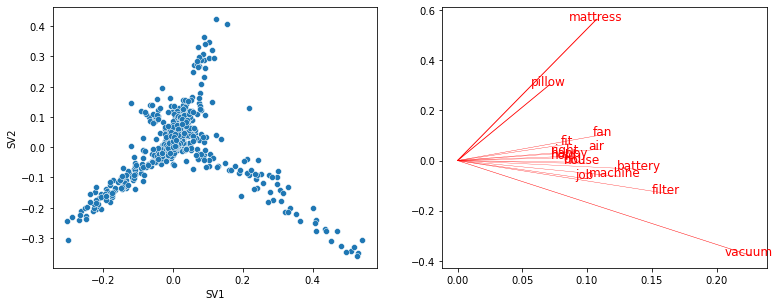

In [13]:
prod_svd_matrix = cl_project_features(
    product_profiles, prod_cl_dict
)

### Grid search

In [14]:
# Insert grid search plots and validation criteria here

### Word clouds

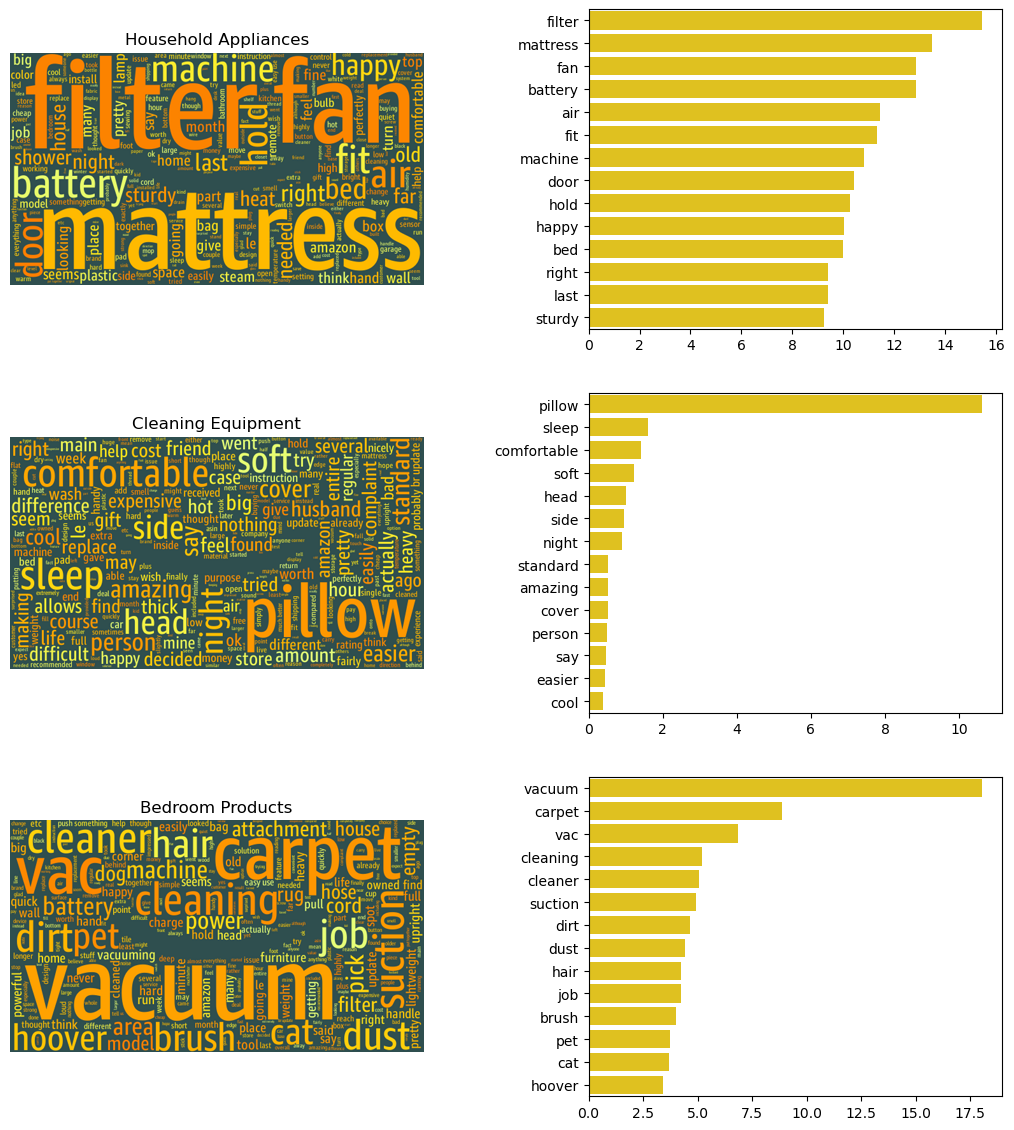

In [21]:
prod_cl_names = ['Household Appliances', 'Cleaning Equipment',
                 'Bedroom Products']
cl_plot_all(prod_cl_dict, product_profiles, 3, wc, prod_cl_names)

## Recsys

### Helper functions

#### Content-based

In [29]:
def cb_recommend(user, df_utility, df_item_profiles, user_profile, L=5):
    """
    Accepts a utility matrix and item profiles then recommends `L` items to
    the user based on their user profile using cosine distance as a measure.
    Sort them by item ID in case of equal distance.
    """
    unrated_idx = df_utility.loc[user][df_utility.loc[user].isna()].index
    distances = []
    for prod_id, row in df_item_profiles.loc[unrated_idx].iterrows():
        if row.sum() == 0:
            continue
        distances.append((prod_id, cosine(user_profile, row)))
    recommended = sorted(distances, key=lambda x: (x[1], x[0]))[:L]
    recos = [id_ for id_, dist in recommended]
    
    wc = WordCloud(
        font_path='AmazonEmberCdRC_Rg.ttf',
        width=800, height=800,
        background_color='white',
        colormap='CMRmap_r',
        max_words=300,
        collocations = False,
        stopwords=stop_words,
        random_state=1337,
    )
    with sns.axes_style('white'):
        plt.imshow(wc.generate_from_frequencies(user_profile))
        plt.axis('off')
        plt.show()
    return recos

#### FIM-based

In [20]:
def fim_get_amazon():
    """Performs clustering on amazon-reviews data using FIM to establish item 
    profiles.
    """
    try:
        fim_df_raw = load_pkl('fim_df_raw')
        print('Pickle file loaded!')
    except:
        # Get data needed for transactions
        conn = sqlite3.connect('amazon.db')
        q = """
            select 
                rate.review_id
                ,rate.customer_id
                ,rate.product_id
                ,rate.star_rating
                ,rev.review_date
            from 
                ratings as rate
                ,reviews as rev
            where
                rate.review_id = rev.review_id
        """
        fim_df_raw = pd.read_sql(q, conn, parse_dates=['review_date'])
        save_pkl(fim_df_raw, 'fim_df_raw')
        
    return fim_df_raw


def fim_tune_period(df, n_reviews=None):
    """Plot number of max elements in a transaction & number of transactions 
    vs period resampling
    """
    try:
        fim_df_res = load_pkl('fim_df_res')
        print('Pickle file loaded!')
    except:
        periods = ['2W', '1M', '3M', '6M', 'Y']
        max_lens = []
        n_transactions = []
        single_itemsets = []
        for period in tqdm(periods):
            df_try = df.copy().iloc[:n_reviews]

            df_try['review_date'] = (
                df_try.loc[:, 'review_date'].dt.to_period(period)
            )
            df_try = (
                df_try.pivot_table(
                    index=['customer_id', 'review_date'],
                    columns='product_id',
                    values='star_rating',
                )
            )
            means = df_try.mean(axis=1)
            df_db = (df_try
                     .sub(means, axis=0)
                     .reset_index()
                     .melt(id_vars=['customer_id', 'review_date'],
                           value_name='star_rating'))
            mask = df_db['star_rating'] >= 0
            df_db = df_db[mask]
            df_db = (
                df_db.groupby(['customer_id', 'review_date'])
                ['product_id'].unique()
            )

            transaction_lens = df_db.apply(lambda x: len(x))

            single_itemsets.append((transaction_lens == 1).sum())
            max_lens.append(transaction_lens.max())
            n_transactions.append(df_db.shape[0])

        fim_df_res = pd.DataFrame(
            {'max_lens': max_lens,
             'n_transactions': n_transactions,
             'single_itemsets': single_itemsets,},
            index=periods
        )
        save_pkl(fim_df_res, 'fim_df_res')
        
    return fim_df_res


def fim_plot_tuning(df_res):
    """Plot the effects of period length to the different parameters of 
    transactions
    """
    fig, axs = plt.subplots(df_res.shape[1], 1,
                            figsize=(15, 4*df_res.shape[1]))
    fig.tight_layout(h_pad=5)
    titles = ['Maximum Number of Products in a Transaction',
              'Number of Transactions',
              'Number of Single-Itemset Transactions']
    for i, col in enumerate(df_res.columns):
        sns.lineplot(y=df_res[col], x=df_res.index, ax=axs[i])
        axs[i].set_title(titles[i], fontsize=15)
        
        
def fim_get_rules(df, supp, conf):
    """Get rules for the recommender system
    """
    try:
        fim_df = load_pkl('fim_df')
    except:
        for _ in trange(1):
            try:
                df_db = load_pkl('df_db')
                print('Transaction database loaded')
            except:
                print('Transaction database loading failed')
                df_db = (
                    df
                    .groupby(['customer_id'])['product_id']
                    .unique()
                    .apply(lambda x: list(x))
                    .tolist()
                )
                df_db = [x for x in df_db if len(x) > 1]
                save_pkl(df_db, 'df_db')
        for _ in trange(1):
            try:
                num = load_pkl('num')
                denom = load_pkl('denom')
            except:
                num = fim.fpgrowth(
                    df_db,
                    target='s',
                    zmin=2,
                    zmax=2,
                    supp=supp,
                    report='a'
                )
                save_pkl(num, 'num')
                denom = fim.fpgrowth(
                    df_db,
                    target='s',
                    zmin=1,
                    zmax=1,
                    supp=supp,
                    report='a'
                )
                save_pkl(denom, 'denom')
                
            dict_denom = {x[0][0]: x[1] for x in denom}
            results = []
            for itemset, value in num:
                if value/dict_denom[itemset[0]] >= conf/100:
                    results.append({
                        'antecedent': itemset[0],
                        'consequent': itemset[1],
                        'confidence': value/dict_denom[itemset[0]]
                    })
                elif value/dict_denom[itemset[1]] >= conf/100:
                    results.append({
                        'antecedent': itemset[1],
                        'consequent': itemset[0],
                        'confidence': value/dict_denom[itemset[1]]
                    })

        fim_df = (pd.DataFrame()
                  .from_dict(results)
                  .pivot_table(index='antecedent',
                               columns='consequent',
                               values='confidence',
                               fill_value=0))
        save_pkl(fim_df, 'fim_df')
        
    return fim_df

#### Pipeline functions

In [116]:
def get_user_rates():
    """Get the data of users with their list of rated items and number of 
    rated items
    """
    try:
        df_user_rates = load_pkl('df_user_rates')
    except:
        conn = sqlite3.connect('/mnt/processed/private/msds2023/lt5/'
                               'dmw2-project/amazon.db')
        q = """
            select 
                rate.review_id
                ,rate.customer_id
                ,rate.product_id
                ,rate.star_rating
                ,rev.review_date
            from 
                ratings as rate
                ,reviews as rev
            where
                rate.review_id = rev.review_id
        """
        df = pd.read_sql(q, conn, parse_dates=['review_date'])
        df_user_rates = (
            df
            .groupby(['customer_id'])['product_id']
            .unique()
            .apply(lambda x: list(x))
            .to_frame()
        )
        df_user_rates['n_rate'] = df_user_rates['product_id'].apply(len)
        save_pkl(df_user_rates, 'df_user_rates')
    
    return df_user_rates


def generic_recommend(user, prod_clusters, product_profiles, amazon_df, L=10):
    """Recommend stratified popular items
    """
    df_gen = pd.DataFrame(prod_clusters,
                          columns=['labels'],
                          index=product_profiles.index)
    df_pivot = (
        amazon_df
        .astype({'star_rating': 'float'})
        .groupby('product_id')['star_rating']
        .value_counts('rates')
        .rename('rates')
        .reset_index()
    )
    df_pivot['wRate'] = df_pivot['star_rating'] * df_pivot['rates']
    df_wRate = df_pivot.groupby('product_id')['wRate'].sum()
    
    n_reco = L // df_gen['labels'].nunique()
    remainder = L % df_gen['labels'].nunique()
    recos = []
    for i in range(remainder):
        mask =  df_gen['labels'] == i
        recos.extend(
            df_wRate[mask].sort_values(ascending=False)[:n_reco+1].index.to_list()
        )
    
    for i in range(df_gen['labels'].nunique() - remainder):
        mask =  df_gen['labels'] == i + remainder
        recos.extend(
            df_wRate[mask].sort_values(ascending=False)[:n_reco+1].index.to_list()
        )
        
    return recos[:L]
        
    
#     names = 'ABCDEFGH'
    
#     for i, name in enumerate(names):
#         exec(f'{name} = n_reco')
        
#     for i in range(L%df_gen['labels'].nunique()):
#         exec(f'{names[i]} += 1')
    
#     A, B, C = n_reco, n_reco, n_reco
    
#     if L % df_gen['labels'].nunique() == 1:
#         A += 1
#     elif L % df_gen['labels'].nunique() == 2:
#         A += 1
#         B += 1
    
    recos = []
    for i, n in enumerate(names):
        mask =  df_gen['labels'] == i
        recos.extend(
            df_wRate[mask].sort_values(ascending=False)[:exec(f'{n}')].index.to_list()
        )
    
    return recos


def fim_recommend(user, df_user_rates, fim_df, L=10):
    """Recommend items based on established FIM rules based on the liked value
    of a user
    """
    likes = df_user_rates.loc[user, 'product_id']
    w_rules = [item for item in likes if item in fim_df.index]
    df_reco = (
        fim_df
        .loc[w_rules]
        .melt()
        .set_index('consequent')
        .sort_values('value', ascending=False)
    )
    mask = df_reco['value'] > 0
    recos = df_reco[mask].index.to_list()
    
#     if len(recos) < L:
#         M = L - len(recos)
#         recos.extend(generic_recommend(user,
#                                        prod_clusters,
#                                        product_profiles,
#                                        amazon_df, 
#                                        L=M))
    
    return recos


def recommend(user, df_utility, df_item_profiles, user_profile, df_user_rates,
              fim_df, L=5, cust_tresh=62, return_titles=True):
    """Check the number of rated products of the given user and returns the
    case number for implementation of hybrid recommender system.
    """
    n_rate = df_user_rates.loc[user, 'n_rate']
    if n_rate > cust_tresh:
        recos = cb_recommend(user, df_utility, df_item_profiles,
                             user_profile.loc[user], L=L)
    else:
        recos = fim_recommend(user, df_user_rates, fim_df, L=L)

    if return_titles:
        query = f'''
            SELECT product_title
            FROM products
            WHERE product_id IN {tuple(recos)}
        '''
        return pd.read_sql(query, conn).squeeze().tolist()
    return recos

In [57]:
df_util = amazon_df.pivot_table(
    index='customer_id',
    columns='product_id',
    values='star_rating',
    aggfunc='mean'
)

df_user_rates = get_user_rates()

fim_df_raw = joblib.load('/mnt/processed/private/msds2023/lt5/dmw2-project/'
                         'pickles/fim_df_raw.pkl')
fim_df = fim_get_rules(fim_df_raw, -5, 60)

In [126]:
prod_clusters = prod_cl_dict[3]

### Demo

In [61]:
df_user_rates[df_user_rates.n_rate == 30]

,product_id,n_rate
customer_id,,
70265,"[B000DZFTBW, B000DZDPI6, B003G2ZKQ8, B004X32N5...",30
377246,"[B000YZ3RTW, B002U0K8H8, B003PWNGQU, B0001DSIH...",30
1034069,"[B004P0XFGM, B00VL7H01I, B00X6V4OV6, B00XBQ0D9...",30
1416500,"[B007T8QFO6, B001O7ZCDS, B002S58746, B00IJEXHW...",30
1423050,"[B00M2Q4I4Y, B00YJBHQ1M, B00YJBK6MS, B00YJBUUY...",30
...,...,...
52888262,"[B00A2CQCW6, B0046EC19Y, B004RBGZ48, B00KBBAN5...",30
52957646,"[B00O33025I, B00IMV7I7W, B00LBHBH6C, B00C97F2Q...",30
53035565,"[B003FGTTYY, B009T37H7I, B0009V1WVQ, B000ZYWE0...",30


#### Content-based recommendation

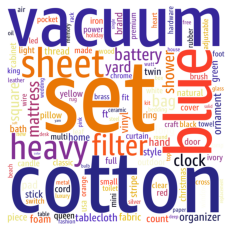

['Sakura Pigma Micron Blister Card Ink Pen Set',
 'Darice Knife and Server Set',
 'Clipperton RollerRings Heavy Duty Roller Shower Curtain Rings, Set of 12',
 'ELAINE KAREN STRIPED 4PC QUEEN Sheet Set, LIGHT BLUE',
 'Cotton Fitted-Sheet Beige - Premium Quality Combed Cotton Long Staple Fiber – Breathable, Durable & Comfortable - Deep Pocket, Hotel Quality By Utopia Bedding (Beige)']

In [39]:
cb_recos = recommend(10804961, df_util, product_profiles,
                     customer_profiles,
                     df_user_rates, fim_df)
cb_recos

#### FIM-based recommendation

In [151]:
fim_recos = recommend(1828069, df_util, product_profiles,
                      customer_profiles,
                      df_user_rates, fim_df)
fim_recos

['Leachco Snoogle Original Total Body Pillow',
 'LiftMaster 373LM Garage Door Remote Controls',
 'Hand Painted 3-D Puffer Fish Charm 17mm Lightweight (1)',
 'Hand Painted 3-D Seated Black Cat With Green Eyes Jewelry Charm 20mm (1)',
 'Hoover Vacuum Cleaner Linx Bagless Corded Cyclonic Lightweight Stick Vacuum SH20030']

#### Popularity-based recommendation

In [146]:
new_customers = df_user_rates[df_user_rates.n_rate < 10].index.tolist()

In [150]:
user = np.random.choice(new_customers)

gen_recos = recommend(user, df_util, product_profiles,
                      customer_profiles,
                      df_user_rates, fim_df)
gen_recos

['Leachco Snoogle Original Total Body Pillow',
 "Leachco Back 'N Belly Contour Pillow",
 'LiftMaster 373LM Garage Door Remote Controls',
 '40 Spools Polyester Embroidery Machine Thread',
 'Hoover Vacuum Cleaner Linx Bagless Corded Cyclonic Lightweight Stick Vacuum SH20030']

In [36]:
lemmd_text = load_pkl('lemmd_text')

ids = [9908714, 1015954]

query = f'''
    SELECT ratings.customer_id, ratings.product_id, products.product_title
    FROM ratings
    INNER JOIN products ON ratings.product_id = products.product_id
    WHERE ratings.customer_id IN {tuple(ids)}
'''

z = pd.read_sql(query, conn).groupby('customer_id')['product_id'].apply(list)

In [65]:
query = f'''
    SELECT product_title
    FROM products
    WHERE product_id in {tuple(df_user_rates.loc[10804961]['product_id'])}
'''

xz = pd.read_sql(query, conn)
xz.squeeze().tolist()

In [77]:
for user in df_user_rates.nlargest(50, 'n_rate').index:
    if len(fim_recommend(user, df_user_rates, fim_df, L=5)) == 5:
        print(user)

32405532
52228204


In [74]:
best_kmeans[labels]

{'model': KMeans(random_state=1337),
 'labels': array([0, 0, 0, ..., 0, 0, 4], dtype=int32)}

In [82]:
fim_recommend(52228204, df_user_rates, fim_df, L=5)

['B00AB3XCFG', 'B00CYSA6FK', 'B00M8FXDIQ', 'B0100R120Y', 'B0088PRK2U']

In [99]:
query = f'''
    SELECT product_title
    FROM products
    WHERE product_id in {tuple(['B009OO612O', 'B00BW985DM', 'B00ZEUAZWO', 'B0100RT3D2'])}
'''

xz = pd.read_sql(query, conn)
xz.squeeze().tolist()[:100]

['C37 Candelabra LED Light Bulb 200 Lumen 3W (25W) 3000K E12 Base',
 'Glass Top Jewelry Gem Jar Display Case',
 'Wooden Alarm Clock Handmade Mute Snooze Nightlight With Luminous Needle Gift Idea',
 'Big Digital LED Square Wall Clock - Large, Silent, Easy To Read Display For Home, Office, School Or College Room - Stands On Shelf Or Hangs On Wall']

In [119]:
generic_recommend(52228204, best_kmeans, product_profiles, amazon_df, L=10)[:5]

['B00RENLJE2', 'B000LZRKFC', 'B004J8PAPE', 'B004RDH7Y8', 'B000ARW4NY']

In [ ]:
cluster_names = ['Christmas Decorations',
                 'Wood Furniture',
                 'Light Fixtures',
                 'Bed Essentials',
                 'Movie Posters',
                 'Wall Decorations', 
                 'Bed Features',
                 'Kitchen Fixtures']

In [144]:
query = f'''
    SELECT product_title
    FROM products
    WHERE product_id = 'B0036WEBLI'
'''

x = pd.read_sql(query, conn)
x.iloc[0].tolist()#.squeeze().tolist()

['PFT Transfer Stencil Paper 15 Sheets by Pirate Face Tattoo']

In [120]:
query = f'''
    SELECT product_title
    FROM products
    WHERE product_id in {tuple(['B00RENLJE2', 'B000LZRKFC', 'B004J8PAPE', 'B004RDH7Y8', 'B000ARW4NY'])}
'''

xz = pd.read_sql(query, conn)
xz.squeeze().tolist()

['Coaster Furniture Brown and Copper Finished Accent Table',
 'Master Lock Python Adjustable Locking Cable, 6-Foot',
 'Epica Anti-Slip Machine Washable Anti-Bacterial Bath Mat 16" x 28" Natural Rubber',
 'Advance Time Technology LED 6-inch Alarm Clock',
 'SINGER 9960 Quantum Stylist 600-Stitch Computerized Sewing Machine with Extension Table, Bonus Accessories and Hard Cover']